In [2]:
import sys

import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML

# toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
# sys.path.append(toolPath)

import mnv14 as mnv

display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

print(mnv.version)

Version 1.4


### Local Data Loading

In [3]:
#filePath = 'data/gbsfkilledvif.xlsx'
#data = pd.read_excel(filePath, header=0, index_col=0, parse_date=True, infer_datetime_format=True)
#print(data.columns)

### PI Data Loading

In [4]:
from PI_client2 import pi_client
pi = pi_client()

tags = pi.search_by_point('*shields*kbtu*')[0]
#tags += pi.search_by_point('*shields*kbtu*')[0]
for point in tags:
    print(point)


Shields_ChilledWater_Demand_kBtu
Shields_Electricity_Demand_kBtu
Shields_Steam_Demand_kBtu


#### Pull tags

In [5]:
startDate = '2017-01-01'
endDate = '2018-01-01'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

data = pi.get_stream_by_point(tags, start=startDate, end=endDate, interval=interval, calculation=calculation)

Shields_ChilledWater_Demand_kBtu                  1 / 3    
Shields_Electricity_Demand_kBtu                   2 / 3    
Shields_Steam_Demand_kBtu                         3 / 3    


# Data Section

Q(75%): 2395.95 Q(25%): 112.60
IQR value is 2283.35
('IQRupper', 10387.67, 'IQRlower', -7879.12)
OAT being loaded from master file


/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


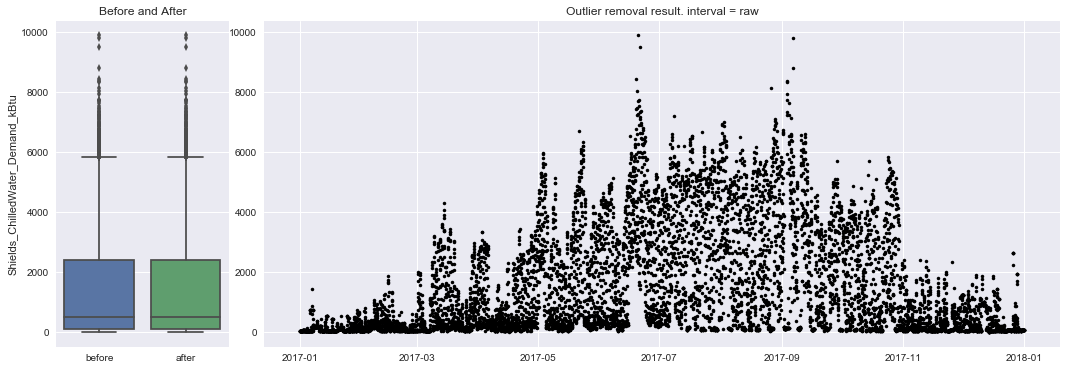

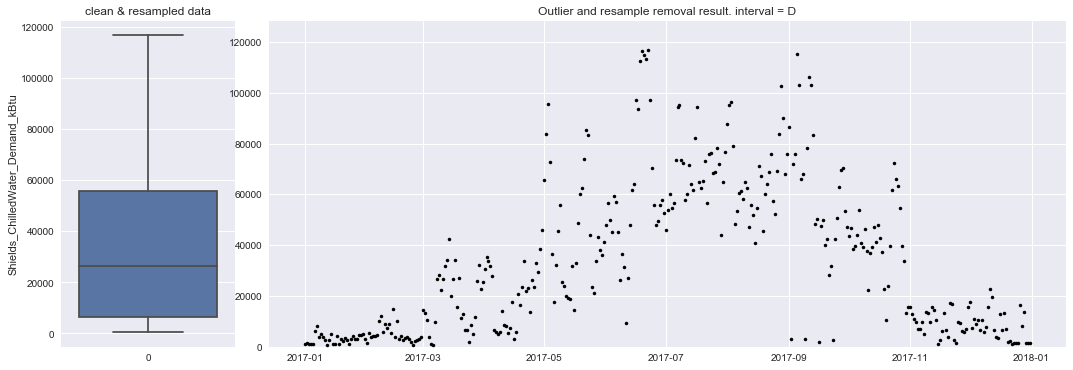

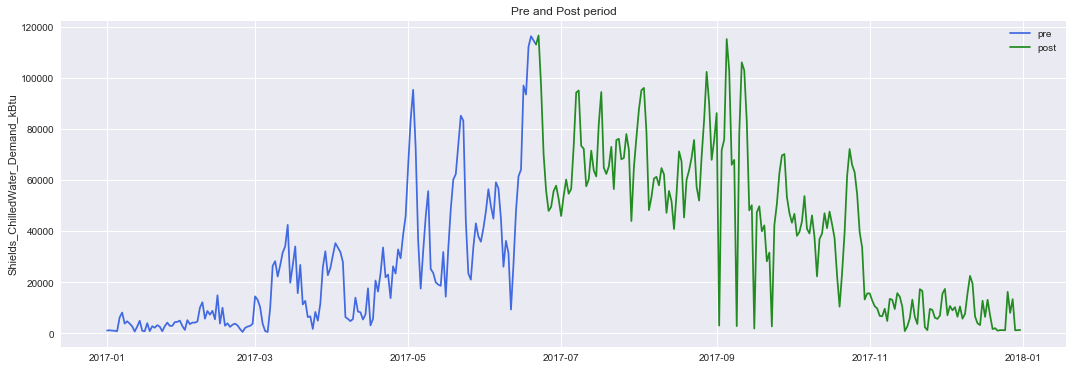

In [6]:

dataParams = {'column': 0,
              'IQRmult' : 3.5,
              'IQR' : 'y', 
              'resampleRate' : 'D', #'D' for daily 'H' for hourly
              'OATsource' : 'file', #'self' or 'file'
              'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
              'sliceType' : 'ranges', #half, middate, ranges
              'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
              'dateRanges' : ['2016-06-01','2017-06-21','2017-06-21','2018-07-30'], #only needed with sliceType : 'ranges'
             }

dk = mnv.data_keeper(data, dataParams)
dk.default_clean()


# Plots
dk._outlier_plot()
dk._resampled_plot(yrange=(-100,dk.modifiedData[dk.com].max()*1.1))
dk._pre_post_plot()

In [7]:
modelParams = {'var': ['CDH','HDH','month','weekday'],
               'testTrainSplit': 'random',
               'randomState': None,
               'testSize': 0.2,
               'commodityRate': 0.0651,
               'varPermuteList': ['', 'C(weekday)', 'C(month)']}
allmod = mnv.many_ols(dk.pre, dk.post, modelParams)

allmod.run_all_linear()
print(allmod.statsPool[0:5])
allmod.plot_pool(1)
modelParams['params'] = allmod.statsPool.iloc[0]['params']

KeyError: 'paramPermuteList'

# Many Linear Models

/anaconda2/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1471: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


        AIC       AR2        R2    cvrmse postDiff                              params                                            summary
22  2675.62  0.974719  0.976206  0.177362  -627333   CDH + HDH + C(weekday) + C(month)                                     OLS Regress...
33  2679.55  0.974891  0.975445  0.176049  -282654              CDH + HDH + C(weekday)                                     OLS Regress...
25  2699.03  0.971173  0.971597  0.183255  -395992                           CDH + HDH                                     OLS Regress...
13  2700.98   0.97347  0.974835  0.181894  -457983                CDH + HDH + C(month)                                     OLS Regress...
30  2706.05  0.967553  0.969462  0.197381  -942413  CDH + HDH2 + C(weekday) + C(month)                                     OLS Regress...


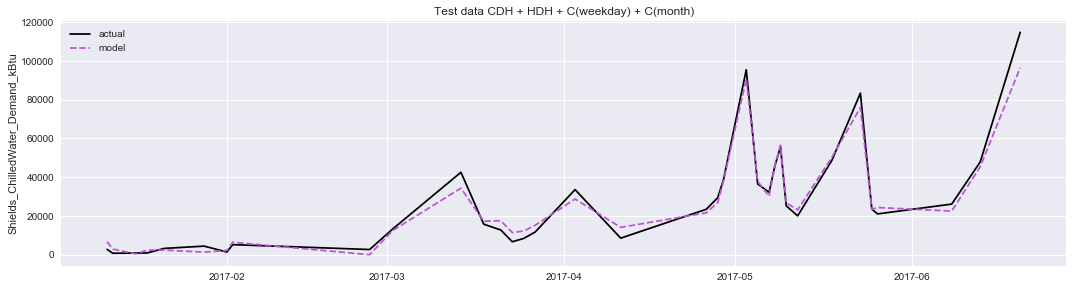

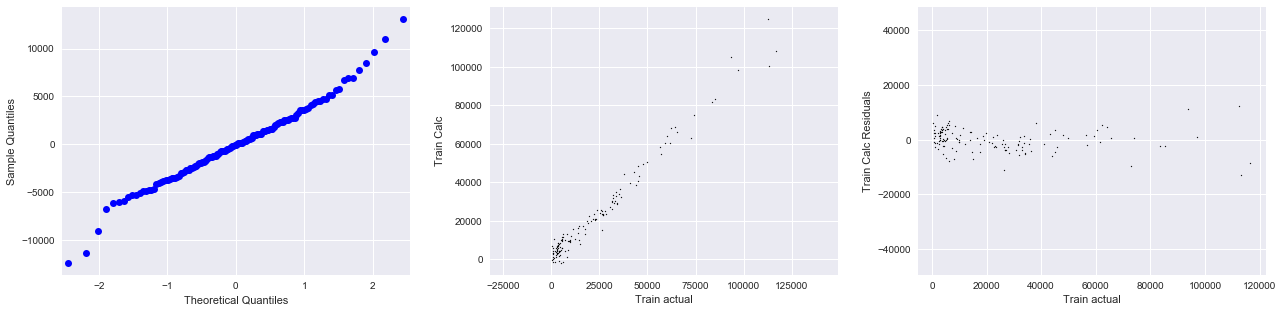

In [7]:
modelParams = {'params': ['CDH','HDH','month','hour','weekday'],
               'testTrainSplit': 'random',
               'randomState': None,
               'testSize': 0.2,
               'commodityRate': 0.0157, #CHW (kBtu)
                #'commodityRate': 0.0190504, #Elec(kBtu)
                #'commodityRate': 0.0059172, #Steam(kBtu)
               #'commodityRate':0.0070000, #Gas (kBtu)
               'paramPermuteList': ['', 'C(weekday)', 'C(month)']}

allmod = mnv.many_ols(dk.pre, dk.post, modelParams)

allmod.run_all_linear()
print(allmod.statsPool[0:5])
allmod.plot_pool(1)
modelParams['params'] = allmod.statsPool.iloc[0]['params']

# Single Linear Model

/anaconda2/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


             VIF
const  39.326408

Kfold
         R2       AR2           mse
4  0.755323  0.740299  9.224499e+06
0  0.644925  0.619563  1.146149e+07
2  0.703860  0.682895  1.271989e+07
1  0.698645  0.677120  1.286183e+07
3  0.674335  0.651279  1.355957e+07
4        7.709274e+01
0        9.578819e+01
2        1.063051e+02
1        1.074913e+02
3        1.133227e+02
<mse>    1.196546e+07
Name: rel. pct., dtype: float64


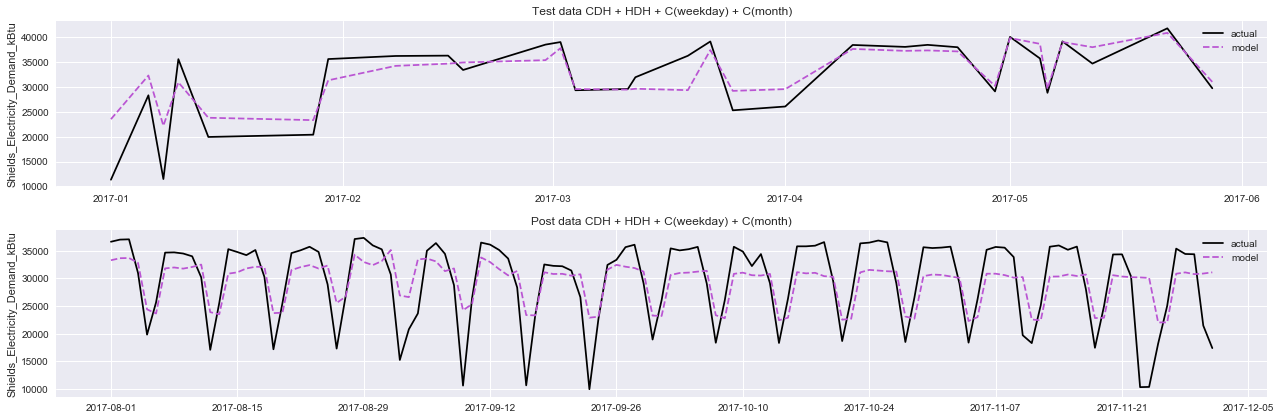

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Shields_Electricity_Demand_kBtu   R-squared:                       0.645
Model:                                         OLS   Adj. R-squared:                  0.620
Method:                              Least Squares   F-statistic:                     25.43
Date:                             Mon, 20 Aug 2018   Prob (F-statistic):           5.90e-22
Time:                                     16:32:22   Log-Likelihood:                -1150.4
No. Observations:                              121   AIC:                             2319.
Df Residuals:                                  112   BIC:                             2344.
Df Model:                                        8                                         
Covariance Type:                         nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2.139e+04   2057.680     10.393      0.000    1.73e+04    2.55e+04
C(weekday)[T.1]  8099.6124    733.909     11.036      0.000    6645.465    9553.760
C(month)[T.2]    4170.6886   1157.433      3.603      0.000    1877.383    6463.994
C(month)[T.3]    6929.1552   1382.255      5.013      0.000    4190.394    9667.917
C(month)[T.4]    6918.7607   1484.502      4.661      0.000    3977.410    9860.111
C(month)[T.5]    7337.6481   1732.103      4.236      0.000    3905.708    1.08e+04
C(month)[T.6]    8165.3691   3779.148      2.161      0.033     677.471    1.57e+04
C(month)[T.7]    1.178e-12   9.87e-14     11.933      0.000    9.82e-13    1.37e-12
C(month)[T.8]            0          0        nan        nan           0           0
C(month)[T.9]            0          0        nan        nan           0           0
C(month)[T.10]           0          0        nan        nan           0           0
C(month)[T.11]           0          0        nan        nan           0           0
C(month)[T.12]           0          0        nan        nan           0           0
CDH                10.3739      5.763      1.800      0.075      -1.045      21.793
HDH                 4.9777      4.540      1.096      0.275      -4.017      13.973
==============================================================================
Omnibus:                       83.360   Durbin-Watson:                   1.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              701.659
Skew:                          -2.213   Prob(JB):                    4.33e-153
Kurtosis:                      13.936   Cond. No.                     2.00e+53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.74e-100. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [7]:
mod = mnv.ols_model(dk.pre, dk.post, modelParams)


mod.model_plot()
mod.calculate_kfold()
mod.calculate_vif()

print(mod.vif[mod.vif['VIF'] > 10])

print('\nKfold')
print(mod.kfoldStats)
print(mod.kfoldRelative)

plt.show() # Show plot before Stats summary
mod.Fit.summary()

### Savings

In [12]:
print(round(mod.postCumsum, 0))
print("Savings = $" +str(round(mod.postCumsum * mod.params.commodityRate,1)))
mod.savings_plot(yaxis='dollars')

-38692.0
Savings = $-607.5


In [13]:
print("Estimated Annual Savings: %0.f" % round(mod.postCumsum/len(dk.post)*365,0))

Estimated Annual Savings: -72797
